In [1]:
import sys
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:
from coco.job import Job

In [3]:
print Job.list()

['f3d_depth_limited_thesis', 'nyu_depth_thesis', 'bu_regression_rgbd_f3_thesis']


In [4]:
current_job = Job.from_name("nyu_depth_thesis")

state_run
phase_val
80


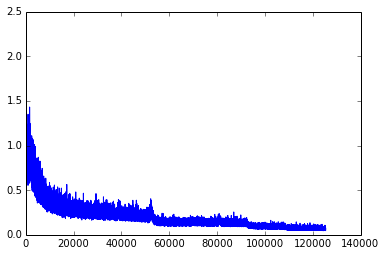

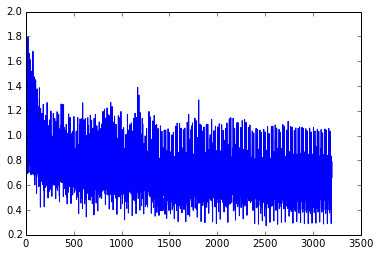

0.645166999512


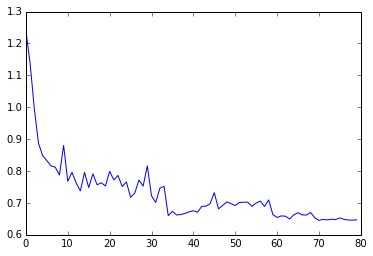

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Refresh job
current_job.load()
data = current_job.data

print data["state"]
print data["phase"]
print data["epoch"]

if "train_losses" in data:
    train_losses = np.array(data["train_losses"]).squeeze()
    plt.plot((train_losses[:]))
    plt.show()

if "val_losses" in data:
    val_losses = np.array(data["val_losses"]).squeeze()
    plt.plot(np.sqrt(val_losses))
    plt.show()
        
    wt = len(train_losses) / data["epoch"]
    wv = len(val_losses) / (data["epoch"])
    
    t = []
    for win in range(0, train_losses.shape[0], wt):
        t.append(train_losses[win:win+wt].mean())
    t = np.sqrt(np.array(t))
    d = []
    for win in range(0, val_losses.shape[0], wv):
        d.append(val_losses[win:win+wv].mean())
    d = np.sqrt(np.array(d))
    
    plt.plot(d)
    
    print d.min()
    


In [ ]:
import sys
import os
import inspect

import numpy as np

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from coco.database_reader import HDF5DatabaseReader
from coco.multiprocess import MultiProcessor
from coco.architectures.depth import DepthPredictionScaffolder, ResidualDepth
from coco.transformations import zoom_rotate, random_rgb, random_crop, normalize_images, downsample, clip, noise, exp

global mean
mean = np.load("/data/food3d/f3d-train.npy")

def process_train(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]

    size = (228, 304)
    
    global mean
    images, labels = exp(images, labels)
    images, labels = zoom_rotate(images, labels)
    images, labels = random_rgb(images, labels)
    images, labels = noise(images, labels)
    images, labels = clip(images, labels, ic=(0. ,255.))
    
    images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    
    images, labels = random_crop(images, labels, size)
    images, labels = downsample(images, labels, (1, 2))

    return images, labels

def process_val(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    global mean

    size = (228, 304)
    images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    images, labels = random_crop(images, labels, size, deterministic=True)
    images, labels = downsample(images, labels, (1, 2))
    
    labels[labels > 1.2] = 0.
    

    return images, labels

train_db = "/data/food3d/f3d-train.hdf5"
val_db = "/data/food3d/f3d-val.hdf5"

batch_size = 16

train_reader = HDF5DatabaseReader(label_key="depths")
train_reader.setup_read(train_db)

val_reader = HDF5DatabaseReader(label_key="depths")
val_reader.setup_read(val_db)

train_processor = MultiProcessor(
    train_reader, func=process_train, batch_size=batch_size)
val_processor = MultiProcessor(
    val_reader, func=process_val, batch_size=batch_size)

scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True)

scaffolder.compile()
scaffolder.load("/data/data/resunet_f3d_limited.npz")

In [ ]:
gt = []
predictions = []
for batch in val_processor.iterate():
    images, labels = batch
    pred = scaffolder.infer(images)[0].squeeze()
    gt.append(labels)
    predictions.append(pred)

In [351]:
g = np.concatenate(gt)
p = np.concatenate(predictions)

In [367]:
# RMSE lin
d = (p - g)
d[g == 0] = 0
d[g > 1.2] = 0

valid = np.ones_like(d)
valid[g == 0] = 0
valid[g > 1.2] = 0
valid = valid.sum()

print np.sqrt((d**2).sum() / valid)

0.119811


In [387]:
# Rel
d = abs(p - g) / g
d[g == 0] = 0
d[g > 1.2] = 0

valid = np.ones_like(d)
valid[g == 0] = 0
valid[g > 1.2] = 0
valid = valid.sum()

print ((d).sum() / valid)

0.129043


In [383]:
# Delta
delta = 1.25 ** 3

a = p / g
b = g / p

m = np.maximum(a,b)

d = np.ones_like(a)
d[m > delta] = 0
d[g == 0] = 0
d[g > 1.2] = 0
d = d.sum()


valid = np.ones_like(a)
valid[g == 0] = 0
valid[g > 1.2] = 0
valid = valid.sum()

print float(d)/float(valid)

0.999908109165


In [386]:
# RMSE log
d = (np.log(p) - np.log(g))
d[g == 0] = 0
d[g > 1.2] = 0

valid = np.ones_like(d)
valid[g == 0] = 0
valid[g > 1.2] = 0
valid = valid.sum()

print np.sqrt((d**2).sum() / valid)

0.161424


In [228]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import numpy as np

t = h5py.File("/data/food3d/f3d-rgbd-infer-train.hdf5")
v = h5py.File("/data/food3d/f3d-rgbd-infer-val.hdf5")

rgbd_t = np.array(t["rgbd"])
bu_t = np.array(t["bus"])

rgbd_v = np.array(v["rgbd"])
bu_v = np.array(v["bus"])


In [229]:
labels_t = np.array(h5py.File("/data/food3d/f3d-labels-train.hdf5")["labels"])
labels_v = np.array(h5py.File("/data/food3d/f3d-labels-val.hdf5")["labels"])


In [230]:
# Generate two folds for the training data
store = {}
for idx in range(labels_t.shape[0]):
    label = labels_t[idx]
    if label not in store:
        store[label] = 0
    else:
        store[label] += 1
    

In [231]:
tuples = []
for k in store:
    tuples.append((k, store[k]))
    
tuples.sort(key= lambda x:x[1])

In [232]:
a = []
b = []

idx = 0
for t in tuples:
    i = idx % 2
    idx += 1
    if i > 0:
        a.append(t)
    else:
        b.append(t)

In [233]:
rgbd_a = []
bus_a = []

rgbd_b = []
bus_b = []

labels_a = [t[0] for t in a]
labels_b = [t[0] for t in b]

s_a = []
s_b = []

for idx in range(labels_t.shape[0]):
    if labels_t[idx] in labels_a:
        rgbd_a.append(rgbd_t[idx].copy()[np.newaxis])
        bus_a.append(bu_t[idx].copy()[np.newaxis])
        s_a.append(labels_t[idx])
    else:
        rgbd_b.append(rgbd_t[idx].copy()[np.newaxis])
        bus_b.append(bu_t[idx].copy()[np.newaxis])
        s_b.append(labels_t[idx])

In [234]:
rgbd_fold2 = np.concatenate([np.concatenate(rgbd_a), rgbd_v])
bu_fold2 = np.concatenate([np.concatenate(bus_a), bu_v])
l_fold2 = np.concatenate([np.array(s_a), labels_v])
rgbd_fold3 = np.concatenate([np.concatenate(rgbd_b), rgbd_v])
bu_fold3 = np.concatenate([np.concatenate(bus_b), bu_v])
l_fold3 = np.concatenate([np.array(s_b), labels_v])

In [235]:
tf2 = h5py.File("/data/food3d/f3d-rgbd-infer-f2-train.hdf5")
vf2 = h5py.File("/data/food3d/f3d-rgbd-infer-f2-val.hdf5")

tf2.create_dataset("rgbd", data=rgbd_fold2)
tf2.create_dataset("bus", data=bu_fold2)
tf2.create_dataset("labels", data=l_fold2)

tf2.close()

vf2.create_dataset("rgbd", data=np.concatenate(rgbd_b))
vf2.create_dataset("bus", data=np.concatenate(bus_b))
vf2.create_dataset("labels", data=np.array(s_b))

vf2.close()



RuntimeError: Unable to create link (Name already exists)

In [236]:
tf3 = h5py.File("/data/food3d/f3d-rgbd-infer-f3-train.hdf5")
vf3 = h5py.File("/data/food3d/f3d-rgbd-infer-f3-val.hdf5")

tf3.create_dataset("rgbd", data=rgbd_fold3)
tf3.create_dataset("bus", data=bu_fold3)
tf3.create_dataset("labels", data=l_fold3)


tf3.close()

vf3.create_dataset("rgbd", data=np.concatenate(rgbd_a))
vf3.create_dataset("bus", data=np.concatenate(bus_a))
vf3.create_dataset("labels", data=np.array(s_a))


vf3.close()



## Compute scatterplot

In [ ]:
import sys
import os
import inspect

import numpy as np
import h5py

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from coco.database_reader import HDF5DatabaseReader
from coco.multiprocess import MultiProcessor
from coco.architectures.regression import BURegressionScaffolder, BURegressor
from coco.transformations import random_rgb, random_crop, normalize_images, downsample, clip, noise, exp, flip_x

global mean
mean = np.load("/data/food3d/f3d-rgbd-train.npy")

def process_train(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]

    size = (228, 304)
    
    global mean
    
    images, _ = normalize_images(images, labels, mean, std=71.571201304890508)
    images, _ = flip_x(images, None)
    images, _ = random_crop(images, None, size)
    
    return images, labels


def process_val(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    
    size = (228, 304)
    
    global mean

    images, _ = normalize_images(images, labels, mean)
    images, _ = random_crop(images, None, size, deterministic=True)

    return images, labels


val_dbs = [
            #("/data/food3d/f3d-rgbd-infer-val.hdf5", "/data/data/bu_regressor_rgbd_infer.npz", "/data/food3d/f3d-labels-val.hdf5"),
            #("/data/food3d/f3d-rgbd-infer-f2-val.hdf5", "/data/data/bu_regressor_rgbd_infer_f2.npz", "/data/food3d/f3d-labels-f2-val.hdf5"),
            #("/data/food3d/f3d-rgbd-infer-f3-val.hdf5", "/data/data/bu_regressor_rgbd_infer_f3.npz", "/data/food3d/f3d-labels-f3-val.hdf5"),
             ("/data/food3d/f3d-rgbd-val.hdf5", "/data/data/bu_regressor_rgbd.npz", "/data/food3d/f3d-labels-val.hdf5"),
             ("/data/food3d/f3d-rgbd-f2-val.hdf5", "/data/data/bu_regressor_rgbd_f2.npz", "/data/food3d/f3d-labels-f2-val.hdf5"),
             ("/data/food3d/f3d-rgbd-f3-val.hdf5", "/data/data/bu_regressor_rgbd_f3.npz", "/data/food3d/f3d-labels-f3-val.hdf5"),
            # ("/data/food3d/f3d-labels-val.hdf5", "/data/data/bu_regressor.npz", "/data/food3d/f3d-labels-val.hdf5"),
            # ("/data/food3d/f3d-labels-f2-val.hdf5", "/data/data/bu_regressor_f2.npz", "/data/food3d/f3d-labels-f2-val.hdf5"),
            # ("/data/food3d/f3d-labels-f3-val.hdf5", "/data/data/bu_regressor_f3.npz", "/data/food3d/f3d-labels-f3-val.hdf5"),
            
          ]

scaffolder = BURegressionScaffolder(BURegressor, 
                                           inference=True,
                                           with_depth=True
                                   )
                                           


scaffolder.compile()
tags = []
predictions = []
gt = []
for t in val_dbs:
    val_db, model, label_db = t
    
    label_db = h5py.File(label_db)
    batch_size = 32

    val_reader = HDF5DatabaseReader(label_key="bus", image_key="rgbd")
    val_reader.setup_read(val_db)
    
    val_processor = MultiProcessor(val_reader, func=process_val, batch_size=batch_size)

    scaffolder.load(model)
    
    iteration = 0
    print "Processing db: ", val_db
    for batch in val_processor.iterate():
        indices = range(batch_size * iteration, batch_size * iteration + (batch_size))
        tag = np.array(label_db["labels"][indices])
        images, labels = batch
        prediction = scaffolder.infer(images)[0]
        gt.append(labels)
        predictions.append(prediction)
        tags.append(tag)
        iteration += 1
        assert len(tags) == len(predictions) == len(gt)

INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Compiling inference function.
INFO:coco.multiprocess:Creating multiprocessor instance with batchsize=32 and queue_size=20
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd.npz'


Processing db:  /data/food3d/f3d-rgbd-val.hdf5


In [12]:
total_tags = np.concatenate(tags)
total_gt = np.concatenate(gt)
total_predictions = np.concatenate(predictions)

In [75]:
h = {}
for index in range(total_tags.shape[0]):
    tag = total_tags[index]
    if tag not in h:
        h[tag] = []
    h[tag].append((total_gt[index], total_predictions[index]))    

In [76]:
# Calculate total RMSE
# We agreed on averaging the prediction first in order to make proper estimations
r_preds = []
r_gt = []
for k in h:
    predictions = [v[1] for v in h[k]]
    r_preds.append(np.array(predictions).mean())
    r_gt.append(h[k][0][0])
    

In [77]:
print np.sqrt(((np.array(r_preds) - np.array(r_gt)) ** 2).mean())

1.46305


In [78]:
predictions_b = total_predictions.copy()

In [87]:
from scipy.stats import wilcoxon

print predictions_a.mean()
print predictions_b.mean()

r = wilcoxon(predictions_a.squeeze(), predictions_b.squeeze())

print r.pvalue

3.10416
3.13508
1.52764868515e-12


1.50465


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


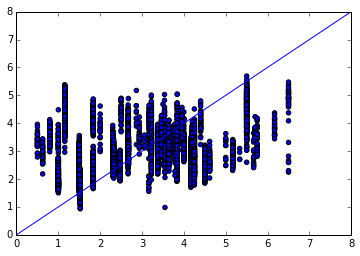

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt


print np.sqrt(np.mean((total_gt.squeeze() - total_predictions.squeeze())**2))

plt.scatter(total_gt.squeeze()[0:], total_predictions.squeeze()[0:])
plt.plot(range(0,9), range(0,9))
plt.axis([0,8,0,8])
plt.show()

In [5]:
agg = []
for key in h:
    preds = [a[1] for a in h[key]]
    agg.append((np.array(preds).mean(), h[key][0][0]))

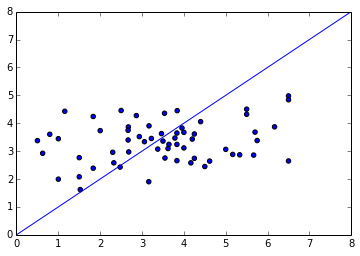

In [6]:
x = [a[1] for a in agg]
y = [a[0] for a in agg]

plt.scatter(x, y)
plt.plot(range(0,9), range(0,9))
plt.axis([0,8,0,8])
plt.show()

In [10]:
box = []
labels = []
for k in h:
    values = [v[1] for v in h[k]]
    box.append(values)
    labels.append(k)
    
labels = [label.replace("_", " ") for label in labels]

NameError: name 'h' is not defined

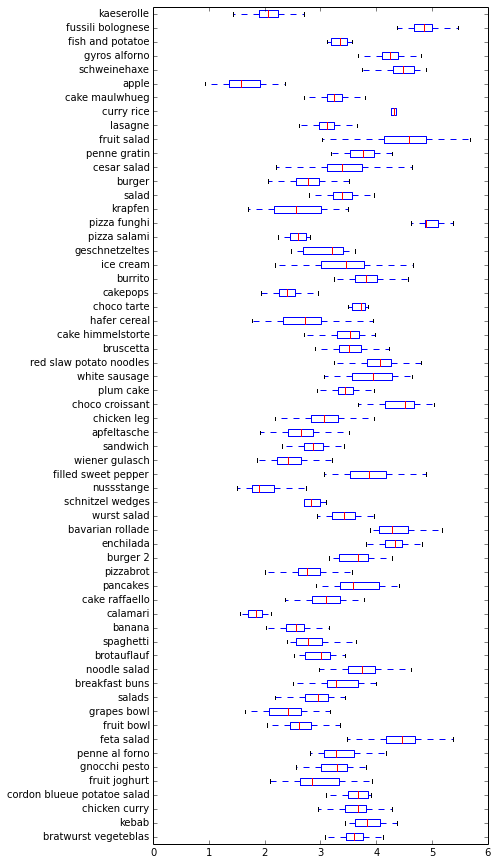

In [30]:
fig = plt.figure(1, figsize=(6, 15))
ax = fig.add_subplot(111)
bp = ax.boxplot(box, 0, "", 0)
ax.set_yticklabels(labels)
plt.show()

In [22]:
data = {"data": box, "labels": labels}

In [24]:
import pickle

pickle.dump(data, open("pred_box.pkl", "wb"))

In [37]:
import pickle
data = pickle.load( open( "box.pkl", "rb" ) )

In [41]:
data.keys()

['ratings', 'labels', 'predictions']

In [48]:
labels = data['labels']
gt = data['ratings']
predictions = data['predictions']

pred=map(np.mean, predictions)

In [58]:
pred

[1.0,
 3.1666666666666665,
 5.666666666666667,
 5.166666666666667,
 0.5,
 4.4000000000000004,
 2.5,
 4.2000000000000002,
 6.5,
 6.5,
 1.5,
 2.6666666666666665,
 5.75,
 4.0,
 4.25,
 1.0,
 2.0,
 0.625,
 4.0,
 4.166666666666667,
 6.166666666666667,
 2.6666666666666665,
 1.8333333333333333,
 4.5,
 1.8333333333333333,
 3.8333333333333335,
 6.5,
 5.5,
 2.2999999999999998,
 4.615384615384615,
 3.0576923076923075,
 2.6730769230769229,
 1.1538461538461537,
 5.333333333333333,
 3.5370370370370372,
 5.5,
 3.7857142857142856,
 4.25,
 3.6206896551724137,
 5.0,
 5.7000000000000002,
 3.8392857142857144,
 3.6428571428571428,
 3.375,
 3.4642857142857144,
 3.8333333333333335,
 1.5,
 3.2222222222222223,
 3.1607142857142856,
 2.4761904761904763,
 3.9545454545454546,
 3.5476190476190474,
 2.8636363636363638,
 3.2272727272727271,
 2.6190476190476191,
 0.69047619047619047,
 2.6190476190476191,
 2.2272727272727271,
 3.5909090909090908,
 1.3333333333333333]

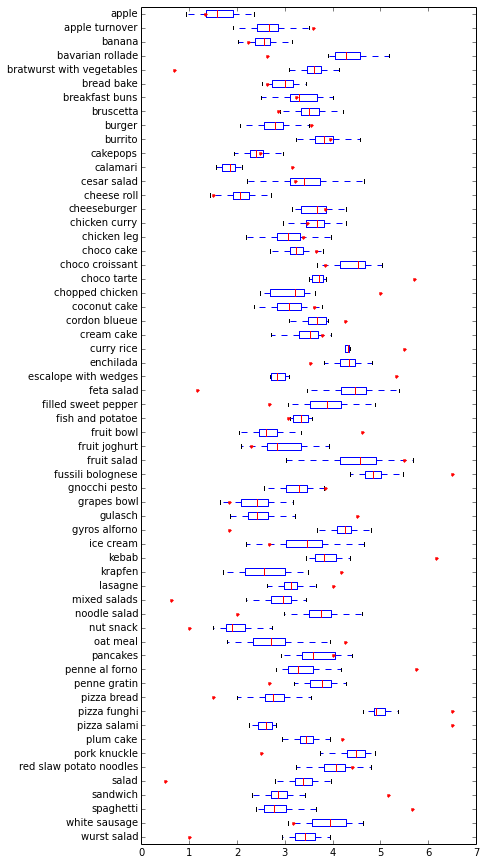

In [65]:
fig = plt.figure(1, figsize=(6, 15))
ax = fig.add_subplot(111)
bp = ax.boxplot(gt, 0, "", 0)
ax.set_yticklabels(labels)

for i in range(len(labels)):
    y = i+1
    x = pred[i]
    #x=i
    plt.plot(x, y, 'r.')
plt.show()

In [60]:
labels

[u'wurst salad',
 u'white sausage',
 u'spaghetti',
 u'sandwich',
 u'salad',
 u'red slaw potato noodles',
 'pork knuckle',
 u'plum cake',
 u'pizza salami',
 u'pizza funghi',
 'pizza bread',
 u'penne gratin',
 u'penne al forno',
 u'pancakes',
 'oat meal',
 'nut snack',
 u'noodle salad',
 'mixed salads',
 u'lasagne',
 u'krapfen',
 u'kebab',
 u'ice cream',
 u'gyros alforno',
 'gulasch',
 u'grapes bowl',
 u'gnocchi pesto',
 u'fussili bolognese',
 u'fruit salad',
 u'fruit joghurt',
 u'fruit bowl',
 u'fish and potatoe',
 u'filled sweet pepper',
 u'feta salad',
 'escalope with wedges',
 u'enchilada',
 u'curry rice',
 'cream cake',
 'cordon blueue',
 'coconut cake',
 'chopped chicken',
 u'choco tarte',
 u'choco croissant',
 'choco cake',
 u'chicken leg',
 u'chicken curry',
 'cheeseburger',
 'cheese roll',
 u'cesar salad',
 u'calamari',
 u'cakepops',
 u'burrito',
 u'burger',
 u'bruscetta',
 u'breakfast buns',
 'bread bake',
 'bratwurst with vegetables',
 u'bavarian rollade',
 u'banana',
 'apple 

(3, 240, 320)